In [1]:
import custom_coco_helper as helper
import os
import json
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

In [2]:
# Constants

DATA_DIR = 'data'

# dir for raw images
DOWNLOAD_DIR = 'raw'
IMAGE_PATH = os.path.join(os.getcwd(), DATA_DIR, DOWNLOAD_DIR)

# dir for intermediate files
IN_PROGRESS_DIR = 'in_progress'
IN_PROGRESS_PATH = os.path.join(os.getcwd(), DATA_DIR, IN_PROGRESS_DIR)

# intermediate files
FINISHED_PATH = os.path.join(IN_PROGRESS_PATH, 'finished.txt')
ANNOTATIONS_PATH = os.path.join(IN_PROGRESS_PATH, 'annotations.txt')
IMG_INFO_PATH = os.path.join(IN_PROGRESS_PATH, 'img_info.txt')

In [3]:
predictor = helper.MyPredictor(IMAGE_PATH)

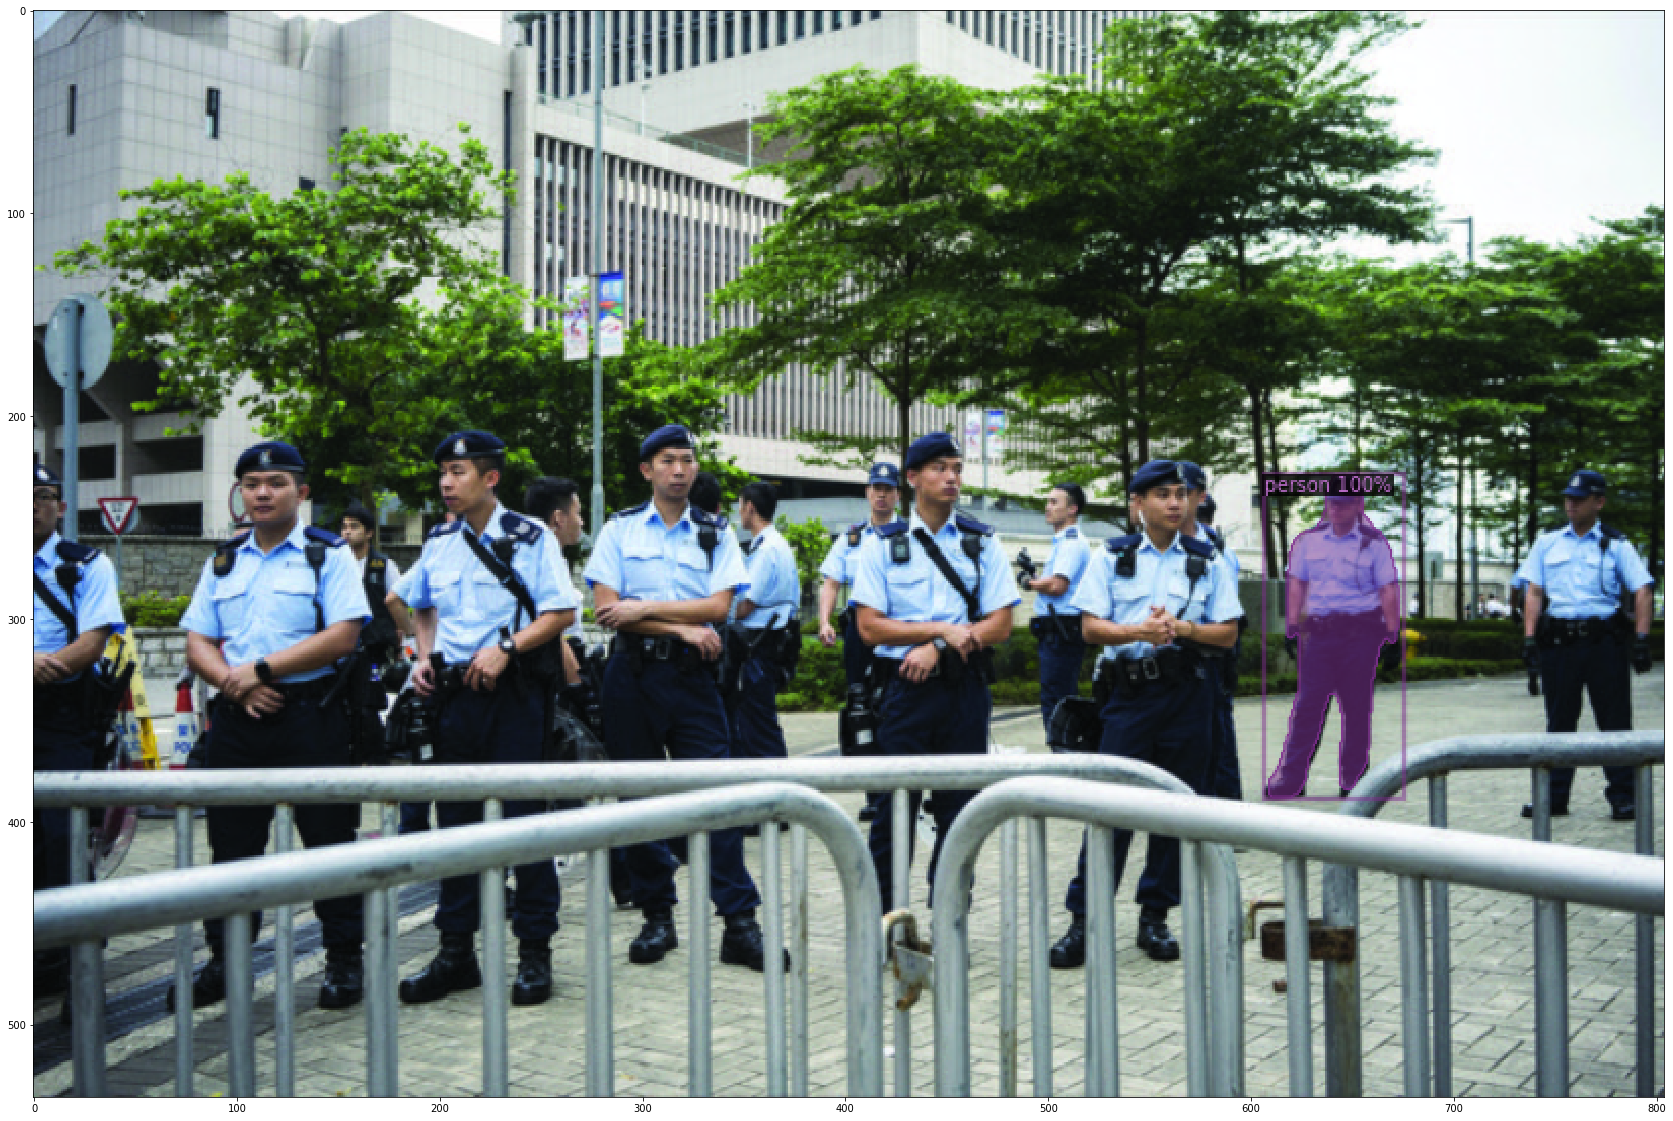

In [9]:
next_seg_id = 1

# Reading in previous processed img paths
finished_img_paths = []
if os.path.exists(FINISHED_PATH):
    with open(FINISHED_PATH, 'r') as f:
        finished_img_paths = map(str.strip, f.readlines())

finished_file = open(FINISHED_PATH, 'a')
annotations_file = open(ANNOTATIONS_PATH, 'a')
img_info_file = open(IMG_INFO_PATH, 'a')

# Setup figure
fig, ax = plt.subplots(1, 1, figsize = (200,20))

# Process 1 image per iteration
try:
    for i in range(predictor.get_num_imgs()):
        # Skip if img was processed before
        img_path = predictor.get_img_path(i)
        if img_path in finished_img_paths:
            continue

        img = predictor.read_img(i)
        results = predictor.inference(img)
        next_seg_id, instances = helper.MyInstance.create_instances(i, next_seg_id, img_path, results, keep_cats=[0])

        # Display each people instance one by one for relabelling
        for instance in instances:
            # Show image
            v = predictor.visualize(img, instance)
            ax.imshow(v)
            display(fig)
            
            # Clear the old image
            clear_output(wait=True)
            
            # Prompt to enter the new category label
            new_category = input("New Category")
            # Discard the instance
            if new_category == 'na':
                continue
            # Discard the image
            elif new_category == 'skip':
                break
            else:
                new_category = int(new_category)
            
            annotation = instance.coco_annotation(new_category)
            if annotation is not None:
                annotations_file.write(json.dumps(annotation) + '\n')

        # No img info for discarded images
        if new_category != 'skip':
            img_info_file.write(json.dumps(instances[0].coco_img_info()) + '\n')
        finished_file.write(img_path + '\n')
except KeyboardInterrupt:
    pass
finally:
    img_info_file.close()
    finished_file.close()
    annotations_file.close()